# 05 - Taming Text

## Deadline
Thursday December 15, 2016 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution
you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code

## Background
In this homework you will explore a relatively large corpus of emails released in public during the
[Hillary Clinton email controversy](https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy).
You can find the corpus in the `hillary-clinton-emails` directory of this repository, while more detailed information 
about the [schema is available here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

## Assignment
1. Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

2. Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. Aggregate 
the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level)
that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo
methods from the sentiment analysis module -- can you find substantial differences?

3. Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.

4. *BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import string
import collections
from os import path
from wordcloud import WordCloud
from PIL import Image
from nltk.corpus import stopwords
from nltk import word_tokenize
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer

# 1.Generate a word cloud based on emails' content

Load email with subjects, already extracted text and raw text.

In [3]:
raws = pd.read_csv('hillary-clinton-emails/Emails.csv',usecols=['ExtractedSubject','ExtractedBodyText','RawText'])
raws.head()

ExtractedSubject  \
0                          FW: Wow   
1                              NaN   
2                Re: Chris Stevens   
3  FVV: Cairo Condemnation - Final   
4                              NaN   

                                   ExtractedBodyText  \
0                                                NaN   
1  B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...   
2                                                Thx   
3                                                NaN   
4  H <hrod17@clintonemail.com>\nFriday, March 11,...   

                                             RawText  
0  UNCLASSIFIED\nU.S. Department of State\nCase N...  
1  UNCLASSIFIED\nU.S. Department of State\nCase N...  
2  UNCLASSIFIED\nU.S. Department of State\nCase N...  
3  UNCLASSIFIED\nU.S. Department of State\nCase N...  
4  B6\nUNCLASSIFIED\nU.S. Department of State\nCa...

We see some NaN extractedSubject/extractedBodytext. After visualizing RawText, a majority of the cases can be explained (e.g no subject, email forwarding,..)
We decide to trust the latter and drop RawText

In [4]:
raws.drop(['RawText'], axis= 1,inplace=True)

In [5]:
def concat_subj_txt(row):
    subj = '' if pd.isnull(row.ExtractedSubject) else row.ExtractedSubject
    text = '' if pd.isnull(row.ExtractedBodyText) else row.ExtractedBodyText
    return subj+text

body = pd.DataFrame()
body['text'] = raws.apply(concat_subj_txt, axis=1)
body.head()

text
0                                            FW: Wow
1  B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...
2                               Re: Chris StevensThx
3                    FVV: Cairo Condemnation - Final
4  H <hrod17@clintonemail.com>\nFriday, March 11,...

Ok. dumb word cloud with concat of all cells.

In [6]:
text = ' '.join(body['text'])

In [7]:
text

'FW: Wow B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary Re: Chris StevensThx FVV: Cairo Condemnation - Final H <hrod17@clintonemail.com>\nFriday, March 11, 2011 1:36 PM\nHuma Abedin\nFw: H: Latest: How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx\nPis print. Meet The Right Wing Extremist Behind Anti-Muslim Film That Sparked Deadly RiotsPis print.\n-•-...-^\nH < hrod17@clintonernailcom>\nWednesday, September 12, 2012 2:11 PM\n°Russorv@state.gov\'\nFw: Meet The Right-Wing Extremist Behind Anti-fvluslim Film That Sparked Deadly Riots\nFrom [meat)\nSent: Wednesday, September 12, 2012 01:00 PM\nTo: 11\nSubject: Meet The Right Wing Extremist Behind Anti-Muslim Film That Sparked Deadly Riots\nhtte/maxbiumenthal.com12012/09/meet-the-right-wing-extremist-behind-anti-musiim-tihn-that-sparked-\ndeadly-riots/\

###  Naive Wordcloud on raw text

In [8]:
def classic_cloud(text):
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

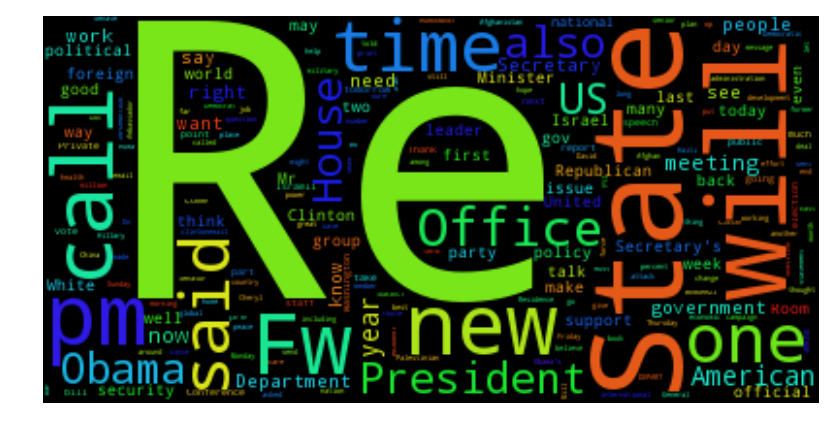

In [9]:
classic_cloud(text)

Not bad. Let's try something more stylish.

In [10]:
def img_cloud(text, img):
    img = Image.open(img)
    img = img.resize((980,1080), Image.ANTIALIAS)
    hcmask = np.array(img)
    wordcloud = WordCloud(background_color="white", max_words=2000, mask=hcmask).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

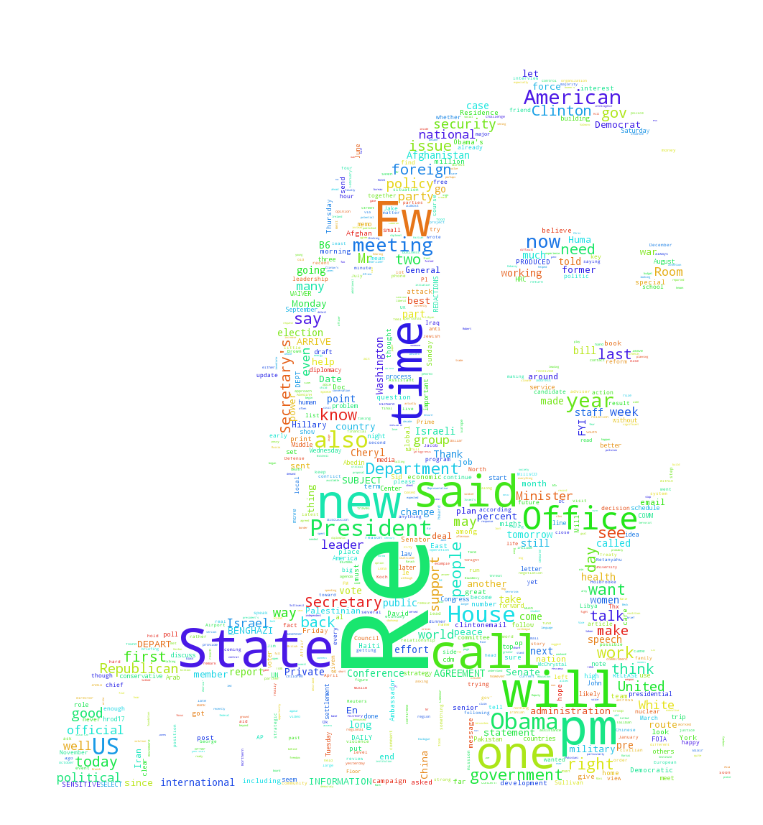

In [11]:
img_cloud(text, 'hc.png')

### WordCloud on clean/preprocessed data
Observe frequent words and remove the ones that are frequent and unwanted

In [12]:
body_tokenized = [i for i in word_tokenize(text.lower())]

In [13]:
stop = set(stopwords.words('english'))
stop.update(string.punctuation) #Remove ponctuation

In [14]:
body_tokenized = [i for i in word_tokenize(text.lower()) if i not in stop]

After removing the 'english' stopwords and the punctuaction, we verify what we still need to remove

In [15]:
counter=collections.Counter(body_tokenized)
print(counter.most_common())

[("'s", 6008), ("''", 4209), ('``', 3675), ('pm', 2171), ('fw', 1850), ('state', 1675), ('would', 1585), ("n't", 1421), ('secretary', 1408), ('call', 1336), ('obama', 1246), ('said', 1242), ('--', 1226), ('new', 1192), ('office', 1175), ('president', 1136), ('one', 1112), ('time', 1017), ('u.s.', 994), ('also', 987), ('house', 977), ('h', 955), ('us', 939), ('—', 899), ('department', 883), ('2010', 830), ('2009', 823), ('people', 819), ('meeting', 804), ('get', 765), ('like', 754), ('clinton', 746), ('know', 724), ('•', 721), ('work', 713), ('government', 706), ('see', 705), ('today', 700), ('could', 697), ('foreign', 650), ('first', 648), ('last', 624), ('american', 615), ('two', 592), ('think', 591), ('back', 586), ('may', 583), ('security', 571), ('women', 569), ('state.gov', 568), ('want', 556), ('states', 555), ('united', 553), ('policy', 552), ('good', 546), ('support', 537), ('political', 535), ('israel', 533), ('world', 533), ('need', 528), ('party', 527), ('room', 508), ('whit

We remove the unwanted words

In [16]:
stop.update(["'s", "''", "``", 'pm', 'fw', "n't", '--']) #Remove other unwanted characters and words

In [17]:
body_tokenized = [i for i in word_tokenize(text.lower()) if i not in stop]
body_tokenized

['wow',
 'b6',
 'thursday',
 'march',
 '3',
 '2011',
 '9:45',
 'h',
 'latest',
 'syria',
 'aiding',
 'qaddafi',
 '...',
 'sid',
 'hrc',
 'memo',
 'syria',
 'aiding',
 'libya',
 '030311.docx',
 'hrc',
 'memo',
 'syria',
 'aiding',
 'libya',
 '030311.docx',
 'march',
 '3',
 '2011',
 'hillary',
 'chris',
 'stevensthx',
 'fvv',
 'cairo',
 'condemnation',
 'final',
 'h',
 'hrod17',
 'clintonemail.com',
 'friday',
 'march',
 '11',
 '2011',
 '1:36',
 'huma',
 'abedin',
 'h',
 'latest',
 'syria',
 'aiding',
 'qaddafi',
 '...',
 'sid',
 'hrc',
 'memo',
 'syria',
 'aiding',
 'libya',
 '030311.docx',
 'pis',
 'print',
 'meet',
 'right',
 'wing',
 'extremist',
 'behind',
 'anti-muslim',
 'film',
 'sparked',
 'deadly',
 'riotspis',
 'print',
 '-•-',
 '...',
 '-^',
 'h',
 'hrod17',
 'clintonernailcom',
 'wednesday',
 'september',
 '12',
 '2012',
 '2:11',
 '°russorv',
 "state.gov'",
 'meet',
 'right-wing',
 'extremist',
 'behind',
 'anti-fvluslim',
 'film',
 'sparked',
 'deadly',
 'riots',
 'meat',
 

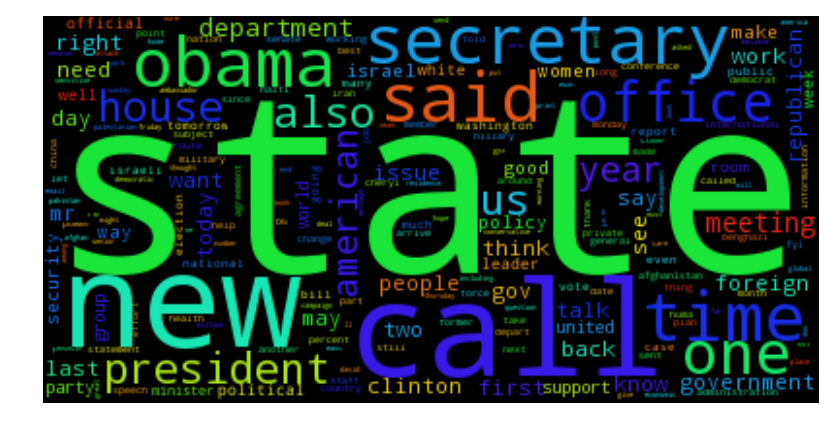

In [18]:
classic_cloud(' '.join(body_tokenized))

If we print body_tokenized, we can see still some unwanted strings like dots ('..', '...'), dates and url. Since they are quite rare, we could ignore their existence for the only purpose of drawing the workdcloud which only considers the most frequent tokens. However, we will need a clean data later on. We thus decide to remove the latters.

In [19]:
print(len(body_tokenized))
r = re.compile('[.]{1,3}$')
dots = set(filter(r.match, body_tokenized))
body_tokenized = [token for token in body_tokenized if token not in dots]
print(len(body_tokenized))

367762
367285


We thus removed 477 tokens. Now, we remove the url and files.

In [20]:
is_file = lambda x: x.endswith('.docx')
is_url = lambda x: x.startswith('htte/') or x.startswith('http/')
body_tokenized = [token for token in body_tokenized if not is_file(token) and not is_url(token)]
print(len(body_tokenized))

367214


It is still not perfect since we still can find some unwanted symbols, useless dates/times and numbers.
Let's now try to apply some normalization techniques on our data.
Two classic methods are Stemming and Lemmatization.

In [23]:
porter = PorterStemmer()
wnl = WordNetLemmatizer()

stemmed = [porter.stem(token) for token in body_tokenized]
lemmatized = [wnl.lemmatize(token) for token in body_tokenized]

We now compute the word frequencies and look in their respective top10 for some potential differences.

In [25]:
count_stemm = collections.Counter(stemmed)
print("################## Stemmed Tokens ####################")
print(count_stemm.most_common()[:10])

count_lemm = collections.Counter(lemmatized)
print("################## Lemmatized Tokens #################")
print(count_lemm.most_common()[:10])

################## Stemmed Tokens ####################
[('state', 2271), ('call', 2013), ('would', 1585), ('secretari', 1460), ('time', 1371), ('offic', 1318), ('work', 1299), ('obama', 1249), ('presid', 1245), ('said', 1242)]
################## Lemmatized Tokens #################
[('state', 2230), ('would', 1585), ('call', 1530), ('secretary', 1460), ('time', 1338), ('obama', 1246), ('said', 1242), ('office', 1203), ('new', 1192), ('u', 1190)]


-----> Talk about differences <-------
We print the lemmatized wordcloud.

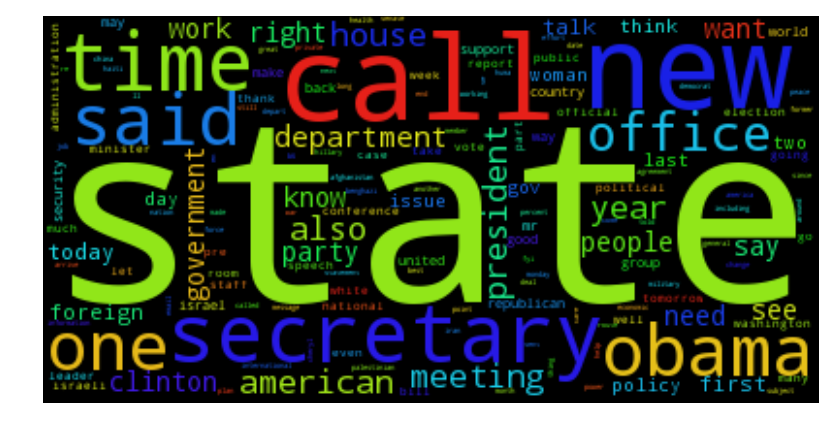

In [28]:
classic_cloud(' '.join(lemmatized))

Not much difference with not stemmed/lemmatized tokens.

---------> discuss pros/cons of each clouds<----------

# 2. Identification of countries and sentiment analysis per email. Aggregation of perceptions on countries.